In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/Deepfold2


In [3]:
import h5py
import pandas as pd
import seaborn as sns
sns.set()

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
# read reactivities
reactivities = {}
sequences = {}
with h5py.File('output/SHAPE-MaP/Cell_2018/cellfree_SHAPE.reactivities', 'r') as f:
    g = f['reactivities']
    for tx_id in g.keys():
        reactivities[tx_id] = g[tx_id][:]
    g = f['sequences']
    for tx_id in g.keys():
        sequences[tx_id] = g[tx_id][()]

In [11]:
# get coverage of each transcript
coverage = []
for rep in ('rep1', 'rep2'):
    for tx_id in sequences:
        r = reactitivies[rep][tx_id]
        coverage.append((rep, tx_id, len(r), float(np.sum(~np.isnan(r)))/len(r)))
coverage = pd.DataFrame.from_records(coverage, columns=['replicate', 'tx_id', 'length', 'coverage'])
coverage.head()

,replicate,tx_id,length,coverage
0,rep1,133,4523,0.961751
1,rep1,132,5162,0.963386
2,rep1,131,8629,0.961062
3,rep1,130,1375,0.866182
4,rep1,137,861,0.839721


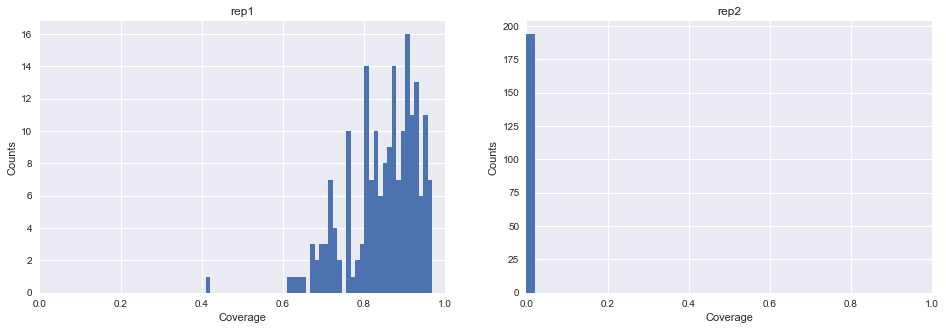

In [48]:
# plot distribution of coverage
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for i, rep in enumerate(('rep1', 'rep2')):
    axes[i].hist(coverage[coverage.loc[:, 'replicate'] == rep]['coverage'].values, bins=50)
    axes[i].set_xlabel('Coverage')
    axes[i].set_ylabel('Counts')
    axes[i].set_title(rep)
    axes[i].set_xlim(0, 1)

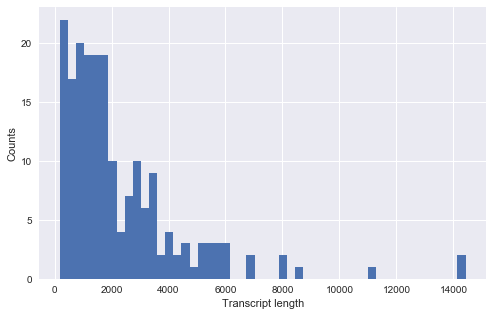

In [22]:
# plot distribution of transcript length
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(coverage[coverage['replicate'] == 'rep1']['length'].values, bins=50)
ax.set_xlabel('Transcript length')
ax.set_ylabel('Counts')

In [ ]:
# plot distribution of SHAPE reactivity
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(coverage[coverage['replicate'] == 'rep1']['re'].values, bins=50)
ax.set_xlabel('Transcript length')
ax.set_ylabel('Counts')

In [57]:
# plot SHAPE reactivities for each nucleotide
tx_ids = sequences.keys()
sequence_concat = np.concatenate([np.frombuffer(sequences[tx_id], dtype='S1') for tx_id in tx_ids])
alphabet = np.frombuffer('AUGC', dtype='S1')
sequence_concat_onehot = (sequence_concat[np.newaxis, :] == alphabet[:, np.newaxis]).astype(np.int8)
reactivities_concat = np.concatenate([reactitivies['rep1'][tx_id] for tx_id in tx_ids])
notnan_mask = ~np.isnan(reactivities_concat) 

In [60]:
sequence_concat_onehot[:, :10]

array([[0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 0, 1, 0, 0, 0, 0, 0, 0]], dtype=int8)

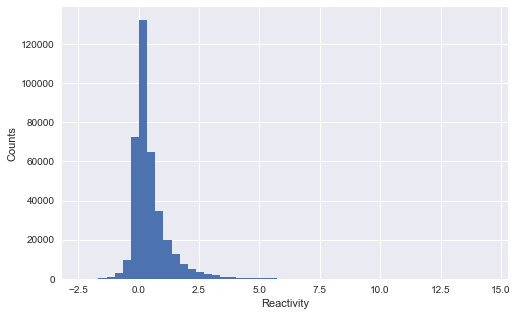

In [34]:
# plot overall distribution of SHAPE reactivity
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(reactivities_concat[~np.isnan(reactivities_concat)], bins=50)
ax.set_xlabel('Reactivity')
ax.set_ylabel('Counts')

(-2, 5)

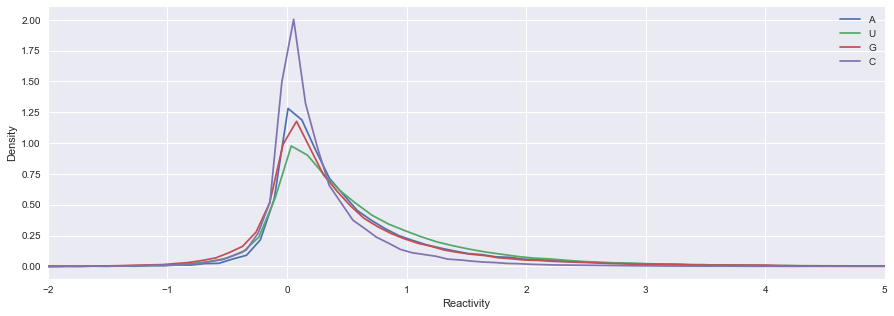

In [73]:
# plot distribution of SHAPE reactivity per nucleotide
fig, ax = plt.subplots(figsize=(15, 5))
for nucleotide in 'AUGC':
    sns.kdeplot(reactivities_concat[notnan_mask & (sequence_concat == nucleotide)], label=nucleotide, ax=ax)
ax.set_xlabel('Reactivity')
ax.set_ylabel('Density')
ax.set_xlim(-2, 5)

In [67]:
# Nucleotide distribution for each SHAPE reactivity bin
n_bins = 50
reactivity_bins = np.linspace(-2, 5, n_bins, endpoint=True)
bin_indices = np.digitize(reactivities_concat[notnan_mask], reactivity_bins)
reactitity_counts = np.zeros((4, n_bins), dtype=np.int64)
for i in range(n_bins):
    reactitity_counts[:, i] = np.sum(sequence_concat_onehot[:, notnan_mask][:, bin_indices == i], axis=1)

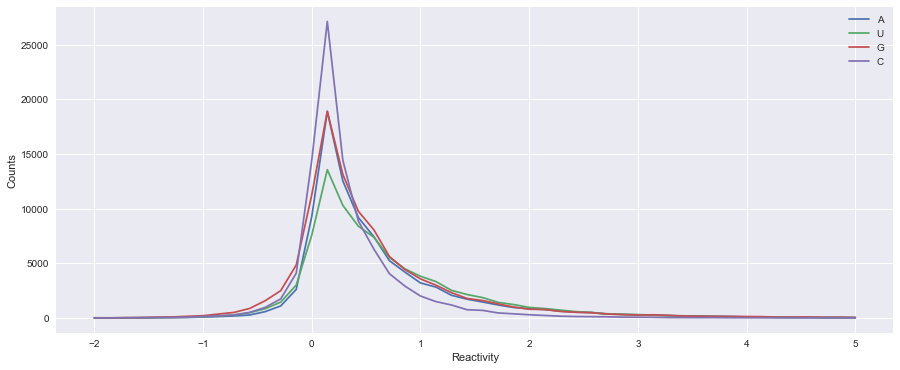

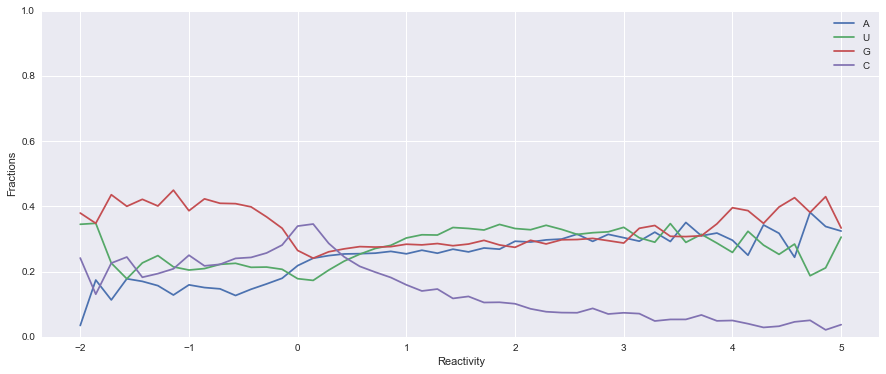

In [79]:
# Nucleotide distribution for each SHAPE reactivity bin
fig, ax = plt.subplots(figsize=(15, 6), sharex=True)
for i, nucleotide in enumerate(alphabet):
    ax.plot(reactivity_bins, reactitity_counts[i], label=nucleotide)
ax.set_xlabel('Reactivity')
ax.set_ylabel('Counts')
plt.legend()
# Normalize counts to fractions
reactivity_fractions = reactitity_counts.astype(np.float64)/np.sum(reactitity_counts, axis=0)
fig, ax = plt.subplots(figsize=(15, 6), sharex=True)
for i, nucleotide in enumerate(alphabet):
    ax.plot(reactivity_bins, reactivity_fractions[i], label=nucleotide)
ax.set_ylim(0, 1)
ax.set_xlabel('Reactivity')
ax.set_ylabel('Fractions')
plt.legend()

In [100]:
# Get ORF regions
orfs_trancript_coord = pd.read_table('output/SHAPE-MaP/Cell_2018/orfs.transcript_coord.bed', 
                                     header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand'])
orfs_trancript_coord.index = orfs_trancript_coord['name']
orfs_trancript_coord['chrom'] = orfs_trancript_coord['chrom'].astype('S')
orfs_trancript_coord.head(10)

,chrom,start,end,name,score,strand
name,,,,,,
thrL,1,43,109,thrL,0,+
thrA,1,190,2653,thrA,0,+
thrB,1,2654,3587,thrB,0,+
thrC,1,3587,4874,thrC,0,+
talB,2,46,1000,talB,0,+
dnaK,3,114,2031,dnaK,0,+
dnaJ,3,2119,3250,dnaJ,0,+
nhaA,4,178,1345,nhaA,0,+
rpsT,5,129,393,rpsT,0,+


In [118]:
x = np.concatenate(reactivities.values())
x[~np.isnan(x)]

array([ 0.01, -0.03, -0.28, ..., -0.13,  0.  ,  0.01], dtype=float32)

(-200, 0)

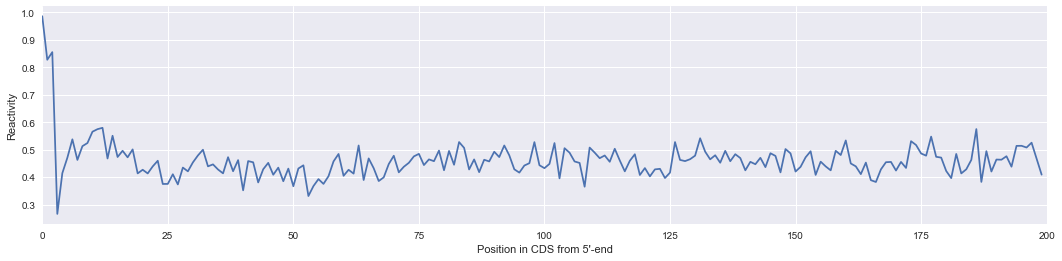

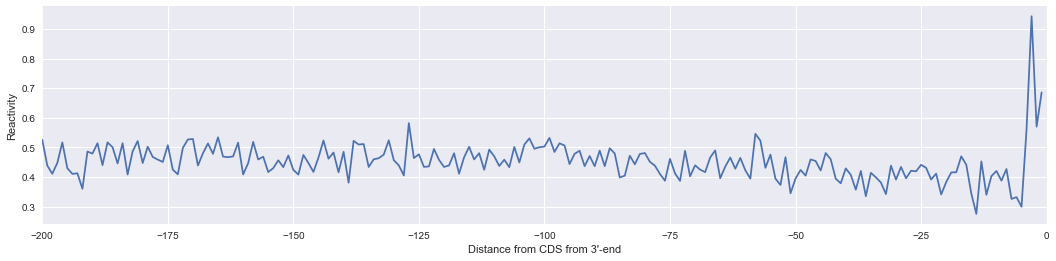

In [126]:
def calc_average_reactivities(direction, aligned_length):
    reactivities_avg = np.full((orfs_trancript_coord.shape[0], aligned_length), np.nan)
    for i, row in enumerate(orfs_trancript_coord.itertuples(index=False)):
        x = reactivities[row[0]][row[1]:row[2]]
        L = min(x.shape[0], aligned_length)
        if direction == '5p':
            reactivities_avg[i, :L] = x[:L]
        elif direction == '3p':
            reactivities_avg[i, -L:] = x[-L:]
    transcript_counts = np.sum(~np.isnan(reactivities_avg), axis=0)
    reactivities_avg = np.nan_to_num(reactivities_avg)
    reactivities_avg = np.sum(reactivities_avg, axis=0)/transcript_counts.astype(np.float64)
    return reactivities_avg

aligned_length = 200
# 5'-end
reactivities_avg_5p = calc_average_reactivities('5p', aligned_length)
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(np.arange(aligned_length), reactivities_avg_5p)
ax.set_xlabel('Position in CDS from 5\'-end')
ax.set_ylabel('Reactivity')
ax.set_xlim(0, aligned_length)

# 3'-end
reactivities_avg_3p = calc_average_reactivities('3p', aligned_length)
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(np.arange(-aligned_length, 0), reactivities_avg_3p)
ax.set_xlabel('Distance from CDS from 3\'-end')
ax.set_ylabel('Reactivity')
ax.set_xlim(-aligned_length, 0)

In [133]:
reactivities_avg_3p.shape

(200,)

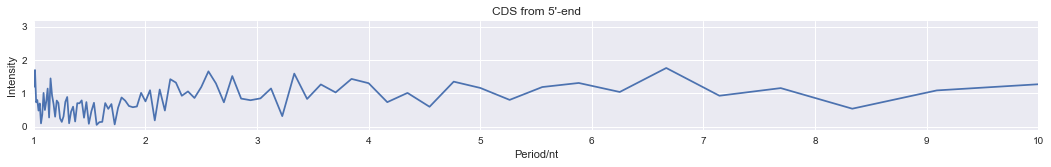

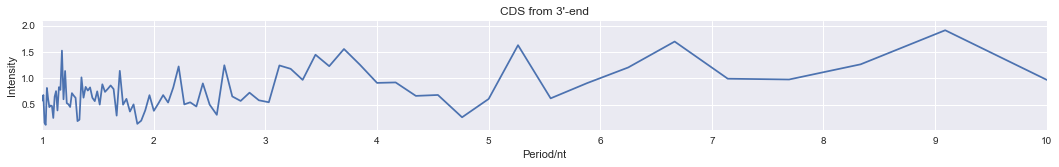

In [136]:
from scipy.fftpack import fft
def plot_fft(signals, title):
    N = signals.shape[0]
    yf = fft(signals)
    fig, ax = plt.subplots(figsize=(18, 2))
    period = float(aligned_length)/np.arange(1, N//2 + 1)
    ax.plot(period[:1:-1], np.abs(yf[0:(N//2)])[:1:-1])
    ax.set_xlim(1, 10)
    ax.set_xlabel('Period/nt')
    ax.set_ylabel('Intensity')
    ax.set_title(title)
plot_fft(reactivities_avg_5p, 'CDS from 5\'-end')
plot_fft(reactivities_avg_3p, 'CDS from 3\'-end')

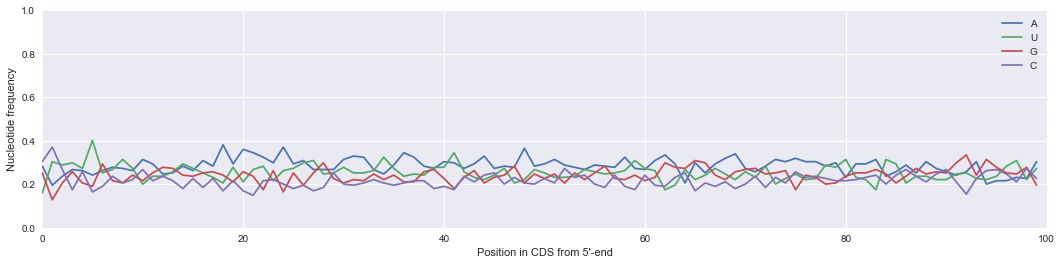

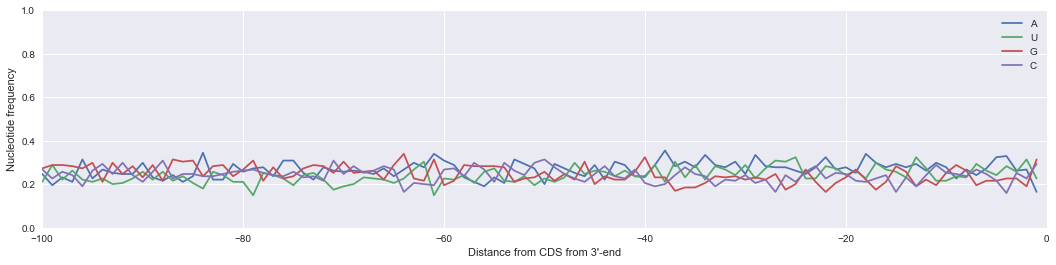

In [130]:
# plot nucleotide frequency at aligned positions
def calc_nucleotide_freq(direction, aligned_length):
    m = np.full((len(tx_ids), aligned_length), 'N', dtype='S1')
    for i, name in enumerate(tx_ids):
        x = np.frombuffer(sequences[name], dtype='S1')
        L = min(x.shape[0], aligned_length)
        if direction == '5p':
            m[i, :L] = x[:L]
        elif direction == '3p':
            m[i, -L:] = x[-L:]
    transcript_counts = np.sum(m != 'N', axis=0)
    m_onehot = (m[:, :, np.newaxis] == alphabet[np.newaxis, np.newaxis, :])
    m_counts = np.sum(m_onehot, axis=0).astype(np.float64)
    m_freq = m_counts/np.sum(m_counts, axis=1)[:, np.newaxis]
    return m_freq

aligned_length = 100
# 5'-end
nucleotide_freq_5p = calc_nucleotide_freq('5p', aligned_length)
fig, ax = plt.subplots(figsize=(18, 4))
for i, nucleotide in enumerate(alphabet):
    ax.plot(np.arange(aligned_length), nucleotide_freq_5p[:, i], label=nucleotide)
ax.set_xlabel('Position in CDS from 5\'-end')
ax.set_ylabel('Nucleotide frequency')
ax.set_xlim(0, aligned_length)
ax.set_ylim(0, 1)
plt.legend()

# 3'-end
nucleotide_freq_3p = calc_nucleotide_freq('3p', aligned_length)
fig, ax = plt.subplots(figsize=(18, 4))
for i, nucleotide in enumerate(alphabet):
    ax.plot(np.arange(-aligned_length, 0), nucleotide_freq_3p[:, i], label=nucleotide)
ax.set_xlabel('Distance from CDS from 3\'-end')
ax.set_ylabel('Nucleotide frequency')
ax.set_xlim(-aligned_length, 0)
ax.set_ylim(0, 1)
plt.legend()

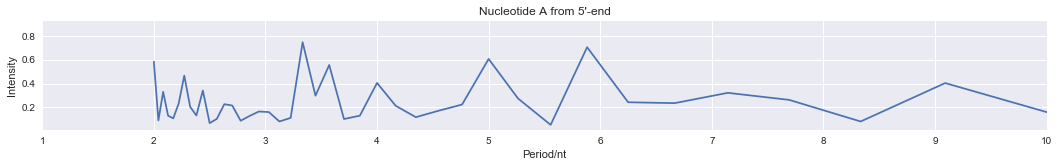

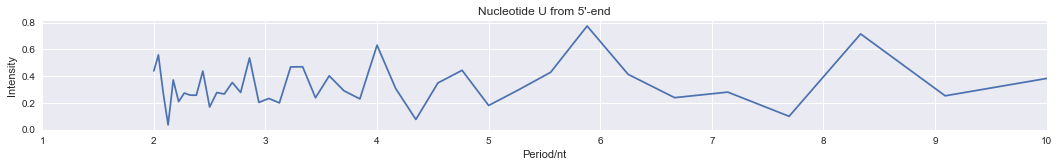

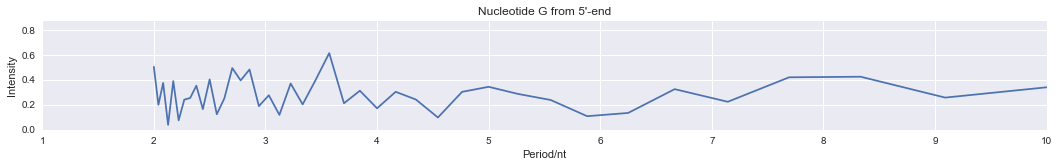

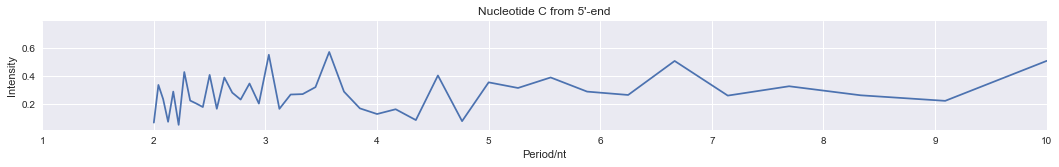

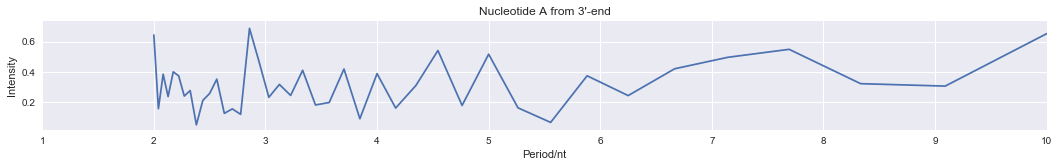

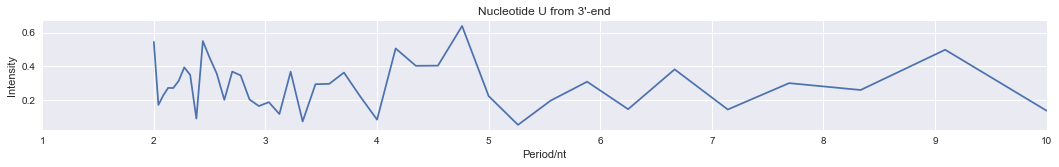

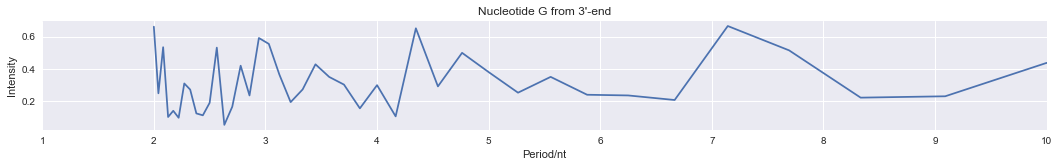

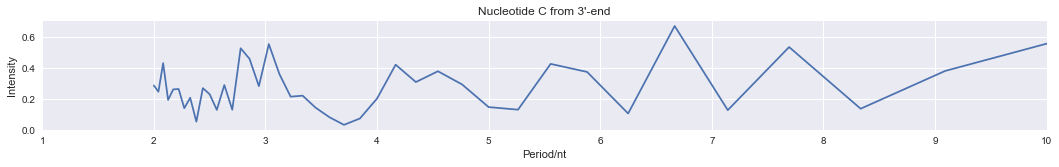

In [137]:
for i, nucleotide in enumerate(alphabet):
    plot_fft(nucleotide_freq_5p[:, i], 'Nucleotide %s from 5\'-end'%nucleotide)
for i, nucleotide in enumerate(alphabet):
    plot_fft(nucleotide_freq_3p[:, i], 'Nucleotide %s from 3\'-end'%nucleotide)